# Imports

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from pystoi import stoi # entre 0 et 1. Plus c'est proche de 1, mieux c'est
import scipy
#import torchmetrics
from torch.utils.data import DataLoader
#from torchmetrics.audio.pesq import PerceptualEvaluationSpeechQuality
import torch
#from dummy import Dummy
import torch.nn as nn
import torch.nn.functional as F
import IPython.display as ipd
from scipy.signal import stft, istft
#from dummy_model import Dummy_model
import tqdm
import pandas as pd
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm


In [2]:
SAMPLERATE = 8000

In [3]:
train_files_clean = os.listdir('./data/Audio/voice_origin/train/train/')
train_files_noise = os.listdir('./data/Audio/denoising/train/train/')
test_files_clean = os.listdir('./data/Audio/voice_origin/test/test/')
test_files_noise = os.listdir('./data/Audio/denoising/test/test/')


In [4]:
print('Il y a', len(train_files_clean), 'fichiers d\'entrainement propres')
print('Il y a', len(train_files_noise), 'fichiers d\'entrainement bruités')
print('Il y a', len(test_files_clean), 'fichiers de test propres')
print('Il y a', len(test_files_noise), 'fichiers de test bruités')



Il y a 2118 fichiers d'entrainement propres
Il y a 2118 fichiers d'entrainement bruités
Il y a 782 fichiers de test propres
Il y a 782 fichiers de test bruités


Visualisation d'un signal

In [5]:
index=9
file_clean='./data/Audio/voice_origin/train/train/' + train_files_clean[index]
file_noise='./data/Audio/denoising/train/train/' + train_files_noise[index]
samplerate_clean, data_clean = wavfile.read(file_clean) # sample rate is the sample frequency of the audio
samplerate_noise, data_noise = wavfile.read(file_noise)

In [6]:
print('Data Propre')
ipd.Audio(data=data_clean, rate=samplerate_clean)

Data Propre


In [7]:
print('Data Buitée')
ipd.Audio(data=data_noise, rate=samplerate_noise)

Data Buitée


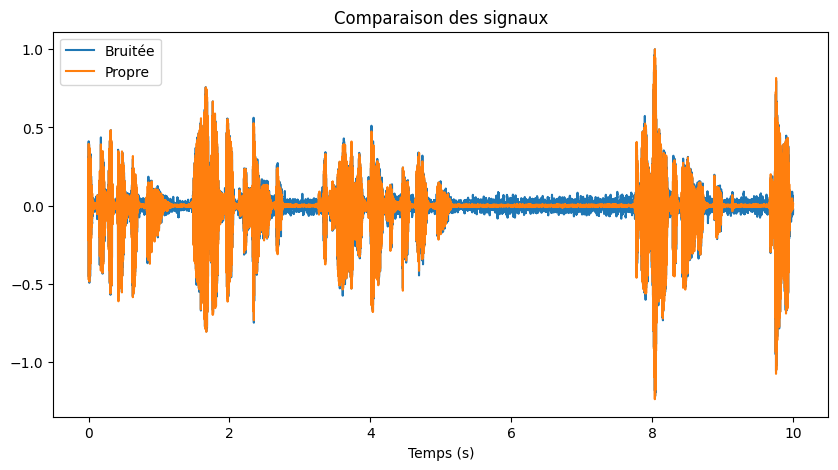

In [8]:
data_clean = data_clean/np.max(data_clean)
data_noise = data_noise/np.max(data_noise)

temps = np.arange(len(data_clean))/SAMPLERATE
plt.figure(figsize=(10,5))
plt.plot(temps, data_noise, label = 'Bruitée')
plt.plot(temps, data_clean, label = 'Propre')
plt.xlabel('Temps (s)')
plt.title('Comparaison des signaux')
plt.legend()

On commence par transformer les données en numpy array et les stocker dans data (pour ne pas avoir à le refaire à chaque fois)

In [9]:
# conversion en npy : 
convert_files = False
  
if convert_files: 
    np.random.seed(0)
    for i in tqdm.tqdm(range(len(test_files_noise))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/test/test/' + file)
        np.save('./data/signaux/test/noisy/' + file + '.npy', data)

    for i in tqdm.tqdm(range(len(test_files_clean))):
        file = test_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/voice_origin/test/test/' + file)
        np.save('./data/signaux/test/origin/' + file + '.npy', data)
        
    for i in tqdm.tqdm(range(len(train_files_noise))):
        file = train_files_noise[i]
        samplerate, data = wavfile.read('./data/Audio/denoising/train/train/' + file)
        samplerate_clean, data_clean=wavfile.read('./data/Audio/voice_origin/train/train/' + file)
        if np.random.random() > 0.8 :
            np.save('./data/signaux/validation/noisy/' + file + '.npy', data)
            np.save('./data/signaux/validation/origin/' + file + '.npy', data_clean)
        else : 
            np.save('./data/signaux/train/noisy/' + file + '.npy', data)
            np.save('./data/signaux/train/origin/' + file + '.npy', data_clean)

# Datasets & DataLoaders

In [3]:
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data):
        self.path_to_data = path_to_data
        self.X = [elt for elt in os.listdir(path_to_data + 'noisy/')]
        self.Y = [elt for elt in os.listdir(path_to_data + 'origin/')]

    def __len__(self):
        assert len(self.X) == len(self.Y)
        return len(self.X)

    def __getitem__(self, idx):
        noised=np.load(self.path_to_data + 'noisy/' + self.X[idx], allow_pickle=True)
        origin=np.load(self.path_to_data + 'origin/' + self.Y[idx],  allow_pickle=True)
        return torch.tensor([noised], dtype=torch.float32), torch.tensor([origin], dtype=torch.float32) # 1, 129, 357 chacuns

In [4]:
dataloader_test = DataLoader(Mydataset('./signaux/test/'), batch_size=10 , shuffle=False)
dataloader_train = DataLoader(Mydataset('./signaux/train/'), batch_size=10 , shuffle=True)
dataloader_validation = DataLoader(Mydataset('./signaux/validation/'), batch_size=10 , shuffle=True)
for batch in dataloader_test :
  print(batch[0].shape, batch[1].shape)
  break

torch.Size([10, 1, 80000]) torch.Size([10, 1, 80000])


/tmp/ipykernel_1630855/3609629397.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  return torch.tensor([noised], dtype=torch.float32), torch.tensor([origin], dtype=torch.float32) # 1, 129, 357 chacuns


# TasNet

In [5]:
class TasNetEncoder(nn.Module):
    def __init__(self, N, L):
        """
        Args:
            N (int): Number of filters (basis signals in the decoder).
            L (int): Length of each filter (segment length).
        """
        super().__init__()
        # Convolutional filters for U and V
        self.conv1d_U = nn.Conv1d(1, N, L, L, bias=False) #N = number of filters, L = length of each filter, stride = L
        self.conv1d_V = nn.Conv1d(1, N, L, L, bias=False)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input mixture signal (batch_size, 1, time_length).
        Returns:
            torch.Tensor: Encoded mixture weights (batch_size, K, N),
                          where K is the number of segments.
        """
        # Apply gated convolutions
        U_out = F.relu(self.conv1d_U(x))  
        V_out = torch.sigmoid(self.conv1d_V(x)) 

        mixture_weights = U_out * V_out

        return mixture_weights.permute(0, 2, 1)


In [6]:
class TasNetSeparator(nn.Module):
    def __init__(self, N, H, P, num_layers, M):
        """
        Args:
            N (int): Number of filters (basis signals in the encoder).
            H (int): Number of hidden units in the LSTM layers.
            P (int): Output dimension of the fully connected layer.
            num_layers (int): Number of LSTM layers.
            M (int): Number of sources to separate (e.g., M = 1 for denoising).
        """
        super().__init__()
        self.M = M

        self.gain = nn.Parameter(torch.ones(1, N))
        self.bias = nn.Parameter(torch.zeros(1, N))

        # LSTM network
        self.lstm = nn.LSTM(N, H, num_layers, batch_first=True, bidirectional=False)

        # Fully connected layer for mask estimation
        self.fc = nn.Linear(H, N * M)  
        self.softmax = nn.Softmax(dim=2)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Encoded mixture weights (batch_size, K, N).
        Returns:
            torch.Tensor: Estimated masks (batch_size, M, K, N).
        """

        mean = x.mean(dim=2, keepdim=True) 
        std = x.std(dim=2, keepdim=True)    
        x_norm = (x - mean) / (std + 1e-8) 
        x_norm = self.gain * x_norm + self.bias  

        # LSTM forward pass
        lstm_out, _ = self.lstm(x_norm)  # (batch_size, K, H)

        # Mask estimation 
        mask_logits = self.fc(lstm_out)  
        masks = mask_logits.view(x.size(0), x.size(1), self.M, -1)  
        masks = self.softmax(masks)  

        return masks.permute(0, 2, 1, 3)  # (batch_size, M, K, N)

In [7]:
import torch
import torch.nn as nn

class TasNetDecoder(nn.Module):
    def __init__(self, N, L):
        """
        Args:
            N (int): Number of filters (basis signals in the encoder/decoder).
            L (int): Length of each filter (segment length).
        """
        super().__init__()
        self.N = N
        self.L = L

        self.basis_filters = nn.Parameter(torch.randn(N, L), requires_grad=True)

    def forward(self, mixture_weights, masks):
        """
        Args:
            mixture_weights (torch.Tensor): Mixture weights (batch_size, K, N).
            masks (torch.Tensor): Masks for each source (batch_size, M, K, N).

        Returns:
            torch.Tensor: Reconstructed waveforms (batch_size, M, time_length).
        """
        # Compute source weights (D_i = W ⊙ M_i)
        source_weights = masks * mixture_weights.unsqueeze(1)  # (batch_size, M, K, N)

        # Reconstruct segments for each source using the basis filters
        source_signals = torch.matmul(source_weights, self.basis_filters)  # (batch_size, M, N, L)

        # Concatenate segments along the time dimension
        batch_size, M, K, L = source_signals.shape
        time_length = K * L
        source_signals = source_signals.view(batch_size, M, time_length)  # (batch_size, M, time_length)

        return source_signals

In [8]:
class TasNet(nn.Module):
    def __init__(self, N, L, H, num_layers, M):
        """
        Args:
            N (int): Number of filters (basis signals in the encoder/decoder).
            L (int): Length of each filter (segment length).
            H (int): Number of hidden units in the LSTM layers.
            num_layers (int): Number of LSTM layers in the separator.
            M (int): Number of sources to separate (e.g., M = 1 for denoising).
        """
        super().__init__()
        self.encoder = TasNetEncoder(N=N, L=L)
        self.separator = TasNetSeparator(N=N, H=H, P=N, num_layers=num_layers, M=M)
        self.decoder = TasNetDecoder(N=N, L=L)

    def forward(self, x):
        """
        Args:
            x (torch.Tensor): Input mixture waveform (batch_size, 1, time_length).
        Returns:
            torch.Tensor: Reconstructed waveforms (batch_size, M, time_length).
        """
        # Encode the input mixture waveform into mixture weights
        mixture_weights = self.encoder(x)  # Shape: (batch_size, K, N)

        # Generate masks for each source
        masks = self.separator(mixture_weights)  # Shape: (batch_size, M, K, N)

        # Reconstruct the waveforms for each source
        reconstructed_waveforms = self.decoder(mixture_weights, masks)

        return reconstructed_waveforms


# Training

In [9]:
def si_snr(y_pred, y_true, eps=1e-8):
    y_true_mean = torch.mean(y_true, dim=-1, keepdim=True)
    y_pred_mean = torch.mean(y_pred, dim=-1, keepdim=True)
    
    y_true = y_true - y_true_mean
    y_pred = y_pred - y_pred_mean
    
    dot_product = torch.sum(y_pred * y_true, dim=-1, keepdim=True)
    target = dot_product * y_true / (torch.sum(y_true ** 2, dim=-1, keepdim=True) + eps)
    noise = y_pred - target
    
    si_snr_value = 10 * torch.log10(torch.sum(target ** 2, dim=-1) / (torch.sum(noise ** 2, dim=-1) + eps))
    return -torch.mean(si_snr_value)


In [10]:
def train_tasnet(model, train_loader, val_loader, si_snr_loss, num_epochs, lr, device):
    """
    Args:
        model (nn.Module): TasNet model.
        train_loader (DataLoader): DataLoader for training data.
        val_loader (DataLoader): DataLoader for validation data.
        si_snr_loss (function): Loss function (SI-SNR).
        num_epochs (int): Number of epochs.
        lr (float): Learning rate for Adam optimizer.
        device (torch.device): Training device (e.g., 'cuda' or 'cpu').
    """
    # Optimizer
    optimizer = Adam(model.parameters(), lr=lr)

    #Loss mse
    criterion = nn.MSELoss()
    
    # Move model to device
    model = model.to(device)
    
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs+1):
        print(f"\nEpoch {epoch + 1}/{num_epochs}")
        print("-" * 50)
        
        # === TRAINING ===
        model.train()
        train_loss = 0.0
        
        for noisy_signals, clean_signals in tqdm(train_loader, desc="Training", leave=False):
            noisy_signals = noisy_signals.to(device)  # (batch_size, 1, time_length)
            clean_signals = clean_signals.to(device)  # (batch_size, 1, time_length)

            # Forward pass
            outputs = model(noisy_signals)  # Shape: (batch_size, M, time_length)

            # Compute loss (SI-SNR)
            #loss = si_snr_loss(outputs.squeeze(1), clean_signals.squeeze(1))  # Squeeze M dimension
            
            #compute mse
            loss = criterion(outputs.squeeze(1), clean_signals.squeeze(1))
            
            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        print(f"Training Loss: {train_loss:.4f}")
        train_losses.append(train_loss)
        
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        
        with torch.no_grad():
            for noisy_signals, clean_signals in tqdm(val_loader, desc="Validation", leave=False):
                
                noisy_signals = noisy_signals.to(device)  
                clean_signals = clean_signals.to(device) 

                # Forward pass
                outputs = model(noisy_signals)
                
                # Compute loss
                #loss = si_snr_loss(outputs.squeeze(1), clean_signals.squeeze(1))

                #mse loss
                
                loss = criterion(outputs.squeeze(1), clean_signals.squeeze(1))

                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
        val_losses.append(val_loss)

        #save every 10 epochs
        if epoch % 10 == 0:
            torch.save(model.state_dict(), f"tasnet_mse_large_epoch_{epoch}.pth")
        
    return train_losses, val_losses
        
        


In [11]:
L = 40   # Segment length (filter length)
N = 500  # Number of filters (basis signals)
H = 512  # Hidden units in LSTM
num_layers = 2  # Number of LSTM layers
M = 1   # Number of sources (e.g., M = 1 for denoising)

# Initialize the TasNet model
tasnet = TasNet(N=N, L=L, H=H, num_layers=num_layers, M=M)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# number of parameters
num_params = sum(p.numel() for p in tasnet.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")

Number of trainable parameters: 4495420


In [30]:
# on entraine!!

train = False

if train:
    t_loss, v_loss = train_tasnet(
            model=tasnet, 
            train_loader=dataloader_train, 
            val_loader=dataloader_validation, 
            si_snr_loss=si_snr, 
            num_epochs=100,  
            lr=3e-4, 
            device=device
        )


In [29]:
save = False

if save:
    # Save to .npy file
    np.save("t_loss_mse_large.npy", t_loss)
    np.save("v_loss_mse_large.npy", v_loss)


# Testing

## Plotting Losses

### SI-SNR loss

In [277]:
# Load back
t_loss = np.load("t_loss_sisnr.npy").tolist()
v_loss = np.load("v_loss_sisnr.npy").tolist()


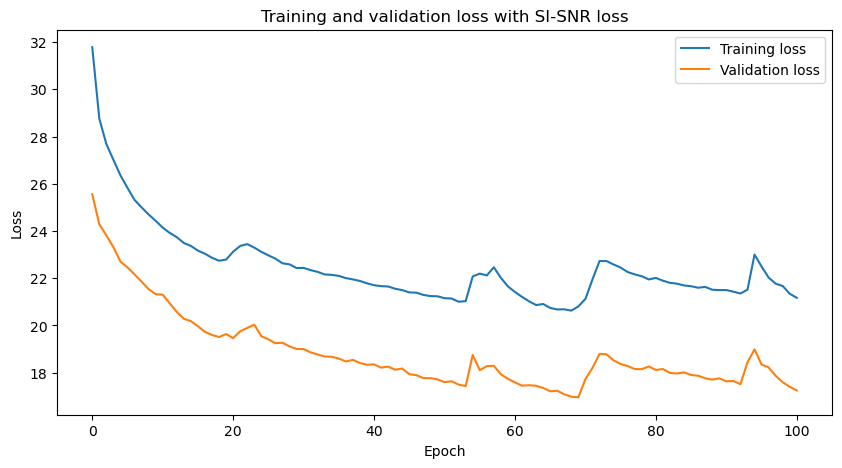

In [276]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Training and validation loss with SI-SNR loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### MSE (small model)

In [280]:
# Load back
t_loss = np.load("t_loss_mse_small.npy").tolist()
v_loss = np.load("v_loss_mse_small.npy").tolist()

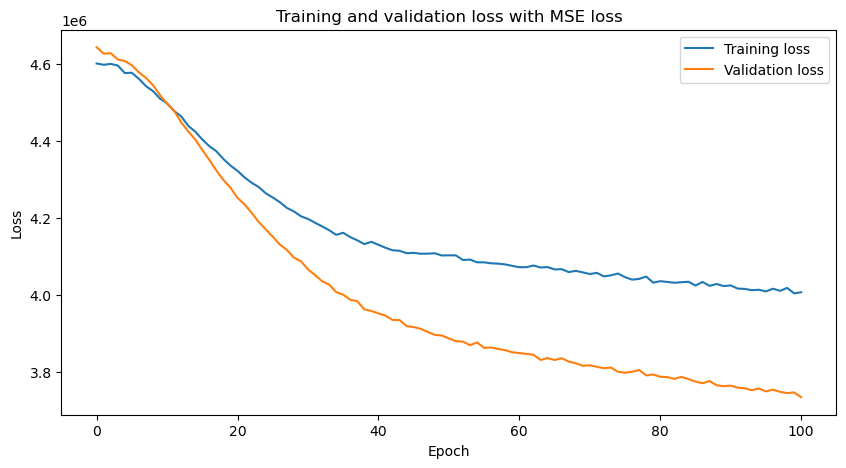

In [281]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Training and validation loss with MSE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### MSE large model

In [15]:
# Load back
t_loss = np.load("t_loss_mse_large.npy").tolist()
v_loss = np.load("v_loss_mse_large.npy").tolist()

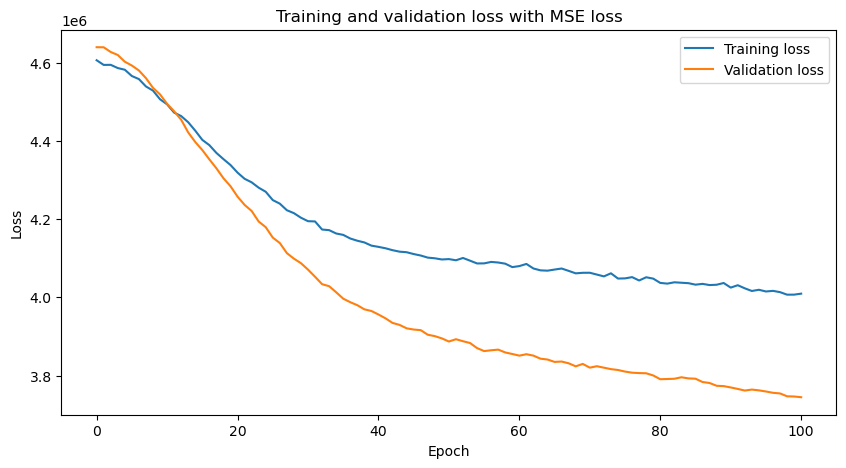

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(t_loss, label='Training loss')
plt.plot(v_loss, label='Validation loss')
plt.title('Training and validation loss with MSE loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Loading models to test

In [21]:
model_snr = TasNet(N=N, L=L, H=512, num_layers=1, M=M)

# Step 2: Load the saved weights
model_snr.load_state_dict(torch.load("tasnet_sisnr_epoch_100.pth"))
num_params = sum(p.numel() for p in model_snr.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")
model_snr

Number of trainable parameters: 2394172


/tmp/ipykernel_1630855/302196306.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_snr.load_state_dict(torch.load("tasnet_sisnr_epoch_100.pth"))


TasNet(
  (encoder): TasNetEncoder(
    (conv1d_U): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
    (conv1d_V): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
  )
  (separator): TasNetSeparator(
    (lstm): LSTM(500, 512, batch_first=True)
    (fc): Linear(in_features=512, out_features=500, bias=True)
    (softmax): Softmax(dim=2)
  )
  (decoder): TasNetDecoder()
)

In [22]:
model_small = TasNet(N=N, L=L, H=128, num_layers=1, M=M)

# Step 2: Load the saved weights
model_small.load_state_dict(torch.load("tasnet_mse_small_epoch_100.pth"))
num_params = sum(p.numel() for p in model_small.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")
model_small

Number of trainable parameters: 448060


/tmp/ipykernel_1630855/4091986042.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_small.load_state_dict(torch.load("tasnet_mse_small_epoch_100.pth"))


TasNet(
  (encoder): TasNetEncoder(
    (conv1d_U): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
    (conv1d_V): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
  )
  (separator): TasNetSeparator(
    (lstm): LSTM(500, 128, batch_first=True)
    (fc): Linear(in_features=128, out_features=500, bias=True)
    (softmax): Softmax(dim=2)
  )
  (decoder): TasNetDecoder()
)

In [24]:
model_large = TasNet(N=N, L=L, H=512, num_layers=2, M=M)

# Step 2: Load the saved weights
model_large.load_state_dict(torch.load("tasnet_mse_large_epoch_100.pth"))
num_params = sum(p.numel() for p in model_large.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {num_params}")
model_large

Number of trainable parameters: 4495420


/tmp/ipykernel_1630855/3755202042.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_large.load_state_dict(torch.load("tasnet_mse_large_epoch_100.pth"))


TasNet(
  (encoder): TasNetEncoder(
    (conv1d_U): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
    (conv1d_V): Conv1d(1, 500, kernel_size=(40,), stride=(40,), bias=False)
  )
  (separator): TasNetSeparator(
    (lstm): LSTM(500, 512, num_layers=2, batch_first=True)
    (fc): Linear(in_features=512, out_features=500, bias=True)
    (softmax): Softmax(dim=2)
  )
  (decoder): TasNetDecoder()
)

## Plotting Results

In [25]:
def unit_norm(signal):
    return signal / np.max(signal)

In [27]:
def plot_results(model, index_to_test):
    dataset = Mydataset('./signaux/test/')
    noised, clean = dataset[index_to_test]

    #pass noisy signal through the model
    model.eval()
    with torch.no_grad():
        output = model(noised.unsqueeze(0))
        #put numpy
        output = output.squeeze(0).cpu().numpy()[0]
    noised = noised.cpu().squeeze(0).numpy()
    clean = clean.squeeze(0).cpu().numpy()

    clean = unit_norm(clean)
    noised = unit_norm(noised)
    output = unit_norm(output)

    temps = np.arange(len(output))/SAMPLERATE
    #figure size
    plt.figure(figsize=(10,5))
    plt.plot(temps, noised, label='Noisy', c='r')
    plt.plot(temps, output, label='Output', c='blue')
    plt.xlabel('Temps (s)')
    plt.legend()
    plt.show()

    #figure size
    plt.figure(figsize=(10,5))
    #plt.plot(noisy_signal, label='Noisy')
    plt.plot(temps, output, label='Output', c='blue')
    plt.plot(temps, clean, label='Clean', c='g')
    plt.xlabel('Temps (s)')
    plt.legend()
    plt.show()


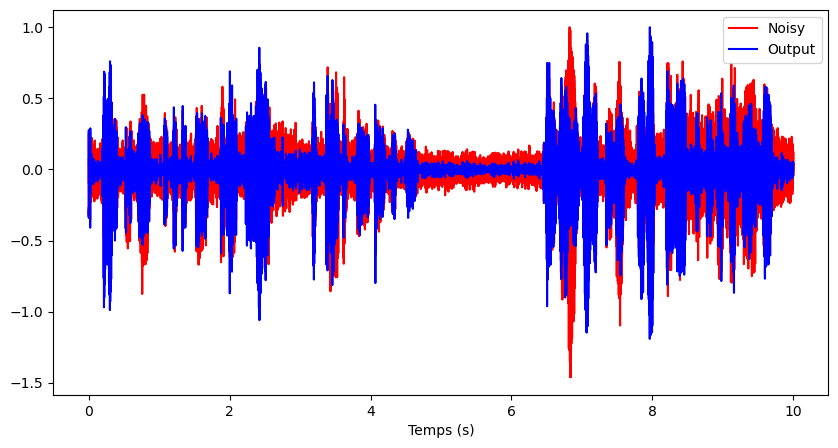

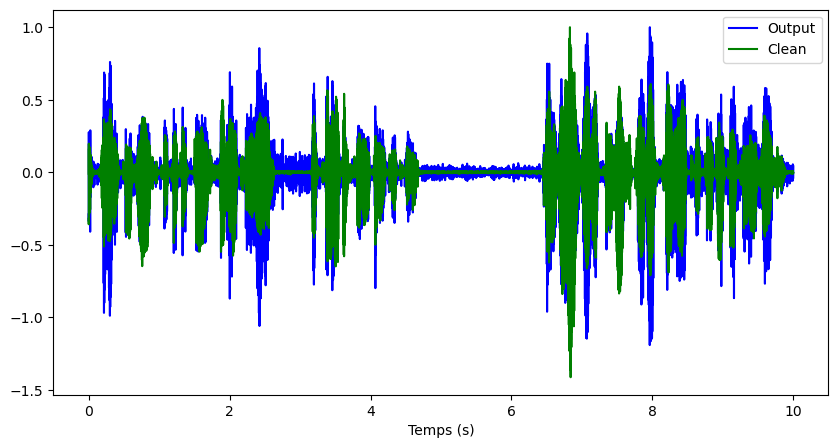

In [28]:
plot_results(model_large,5)

## stoi

In [230]:
original_stoi, new_stoi = stoi(noised, clean, SAMPLERATE) , stoi(output, clean, SAMPLERATE)
print(f"On passe d'un stoi de {original_stoi} à {new_stoi} en denoisant")

On passe d'un stoi de 0.7317042052989522 à 0.4102645256434344 en denoisant


In [70]:
def compute_stoi(model, dataloader):
    stoi_values = []
    for noisy_signals, clean_signals in tqdm(dataloader_test):
        for i in range(len(noisy_signals)):
            noisy_signal = noisy_signals[i]
            noisy_signal = noisy_signal.cpu()
            model.eval()
            with torch.no_grad():
                output = model(noisy_signal.unsqueeze(0))
                output = output.squeeze(0).cpu().numpy()[0]
            stoi_values.append(stoi(clean_signals[i].squeeze(0).cpu().numpy(), output, SAMPLERATE))
    return np.mean(stoi_values)

In [104]:
stoi = compute_stoi(tasnet, dataloader_test)
print(f"Le stoi moyen pour le modèle dummy est de {stoi}")

  0%|          | 0/79 [00:00<?, ?it/s]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor